# Create and Test Model Serving (nuclio) Function
The following notebook demonstrates how to write an inferencing server, test it, and turn it into an auto-scaling nuclio function

## Initialize nuclio emulation, environment variables and configuration
use `# nuclio: ignore` for sections that dont need to be copied to the function

In [38]:
# nuclio: ignore
import nuclio
import random
import matplotlib.pyplot as plt

In [39]:
%%nuclio env
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
version = 1.0

%nuclio: setting 'IMAGE_WIDTH' environment variable
%nuclio: setting 'IMAGE_HEIGHT' environment variable
%nuclio: setting 'version' environment variable


In [40]:
%nuclio env -c MODEL_PATH=/model/
%nuclio env -l MODEL_PATH=./model/

%nuclio: setting 'MODEL_PATH' environment variable


In [41]:
%%nuclio cmd -c
pip install git+https://github.com/fchollet/keras
pip install tensorflow 
pip install numpy
pip install requests
pip install pillow

In [42]:
%%nuclio config 
spec.build.baseImage = "python:3.6-jessie"

%nuclio: setting spec.build.baseImage to 'python:3.6-jessie'


In [74]:
%nuclio mount /model ~/model

mounting volume path /model as ~/model


# Create and Load Model and setup handeler 

In [44]:
import numpy as np 
from tensorflow import keras
from keras.models import load_model
from keras.preprocessing import image
from keras.preprocessing.image import load_img
import json
import requests

import os
from os import environ, path
from tempfile import mktemp

In [45]:
model_file = environ['MODEL_PATH'] + 'cats_dogs.hd5'
prediction_map_file = environ['MODEL_PATH'] + 'prediction_classes_map.json'

# set image parameters
IMAGE_WIDTH = int(environ['IMAGE_WIDTH'])
IMAGE_HEIGHT = int(environ['IMAGE_HEIGHT'])

# load model
def init_context(context): 
    context.model = load_model(model_file)
    with open(prediction_map_file, 'r') as f:
        context.prediction_map = json.load(f)

In [46]:
def download_file(context, url, target_path):
    with requests.get(url, stream=True) as response:
        response.raise_for_status()
        with open(target_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)

    context.logger.info_with('Downloaded file',url=url)

In [47]:
def handler(context, event):
    tmp_file = mktemp()
    image_url = event.body.decode('utf-8').strip()
    download_file(context, image_url, tmp_file)
    
    img = load_img(tmp_file, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    predicted_probability = context.model.predict_proba(images, batch_size=10)
    predicted_class = list(zip(predicted_probability, map(lambda x: '1' if x >= 0.5 else '0', predicted_probability)))
    actual_class = [(context.prediction_map[x[1]],x[0][0]) for x in predicted_class]   
    os.remove(tmp_file)
    return str(actual_class)

# Trigger the function

In [48]:
# nuclio: ignore
init_context(context)

Python> 2019-03-18 17:18:36,395 [info] Downloaded file: {'url': 'https://s3.amazonaws.com/iguazio-sample-data/images/catanddog/dog.979.jpg'}
[('dog', 1.0)]


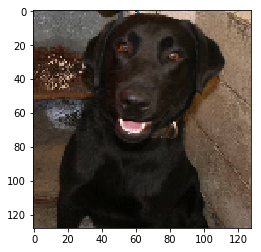

In [60]:
# nuclio: ignore
# Select sample for the test (both local path for test and the URL from S3)
DATA_LOCATION = "./cats_and_dogs_filtered/"
sample = random.choice(os.listdir(DATA_LOCATION+"/cats_n_dogs"))
image_local = DATA_LOCATION + "cats_n_dogs/"+sample #temp to get a file 
image_url = 'https://s3.amazonaws.com/iguazio-sample-data/images/catanddog/' + sample 

# show the image
img = load_img(image_local, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
plt.imshow(img)

event = nuclio.Event(body=bytes(image_url, 'utf-8'))
output = handler(context, event)
#print(f'output:\nclass:{output[0][0]},\tdog-probability:{output[0][1]:.2f}')
print(output)

In [ ]:
%nuclio show

In [ ]:
%nuclio deploy -n cats-dogs -p ai -c -v

In [73]:
!curl -X POST -d "https://s3.amazonaws.com/iguazio-sample-data/images/catanddog/dog.154.jpg" 18.184.175.114:31731

{"class": "dog", "dog-probability": 1.0}